In [4]:
%matplotlib inline


# Collocating eddies and chl data

Script will use py-eddy-tracker methods to upload external data (Satellite chl)
in a common structure with altimetry.

Figures higlights the different steps.


In [5]:
from datetime import datetime

import xarray as xr

# --------------------------------------------------------
# specify the date and lon-lat domain of the analysis here
# --------------------------------------------------------
date = datetime(2016, 9, 1)
extent = [200, 240, 42, 62]

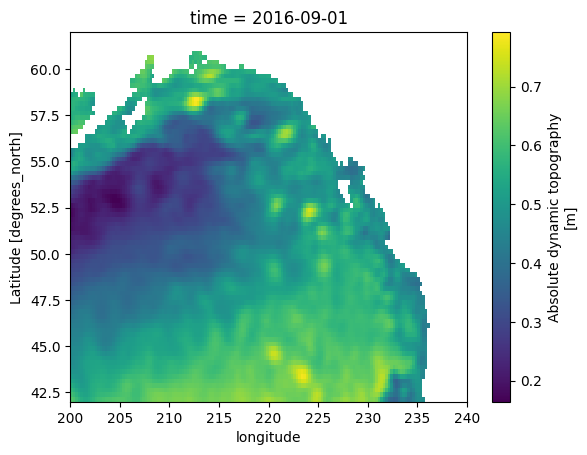

In [6]:
# --------------------------------------------------------
# select date and domain of the altimetry data
# display the analysis domain
# https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/services
# https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/services
# --------------------------------------------------------
ds=xr.open_dataset('~/project36/obs/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_'+str(date.year)+'.nc')
ds1=ds.sel(time=date,method='nearest')
x=ds['longitude']+360
ds1['longitude']=x
ds2=ds1.sel(longitude=slice(extent[0],extent[1])).sel(latitude=slice(extent[2],extent[3]))
ds2.to_netcdf('ssh.nc')
ds2=xr.open_dataset('ssh.nc')
ds2.adt.plot()

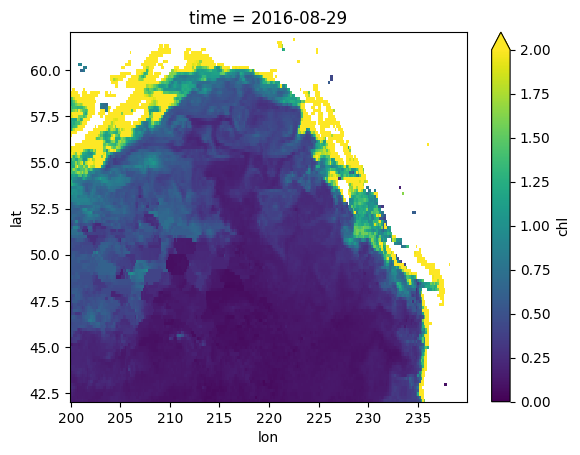

In [7]:
# --------------------------------------------------------
# select date and domain of the chl data
# display the analysis domain
# --------------------------------------------------------
ds=xr.open_dataset('~/project36/obs/chl_MODIS_8day_GOA.nc')
ds1=ds.sel(time=date,method='nearest')
x=ds1['lon'].to_numpy()+360
ds1['lon']=x
ds2=ds1.sel(lon=slice(extent[0],extent[1])).sel(lat=slice(extent[2],extent[3]))
ds2.to_netcdf('chl.nc')
ds2=xr.open_dataset('chl.nc')
ds2.chl.plot(vmin=0,vmax=2)

In [8]:
# --------------------------------------------------------
# import necessary packages
# --------------------------------------------------------
from matplotlib import pyplot as plt
from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset

filename_alt = "ssh.nc"
filename_chl = "chl.nc"
var_name_chl = "chl"

## Loading data



In [9]:
# --------------------------------------------------------
# read in the data using 'RegularGridDataset' 
# --------------------------------------------------------
chl = RegularGridDataset(filename=filename_chl, x_name="lon", y_name="lat", nan_masking=True,)
alti = RegularGridDataset(filename=filename_alt, x_name="longitude", y_name="latitude", nan_masking=True,)
# --------------------------------------------------------
# We can use `Grid` tools, 'regrid' method to interpolate ADT on the sst grid
# This step combines altimetry data into chl gridded dataset
# --------------------------------------------------------
chl.regrid(alti, "adt")
# This step calculate geostrophic circulation based on altimetry data
chl.add_uv("adt")

We assume pixel position of grid is centered for chl.nc
We assume pixel position of grid is centered for ssh.nc


Functions to initiate figure axes



In [10]:
# ---------------------------------------------------------------
# these are helper functions for setting up the plot efficiently
# ---------------------------------------------------------------
def start_axes(title, extent=extent):
    fig = plt.figure(figsize=(13, 6), dpi=120)
    ax = fig.add_axes([0.03, 0.05, 0.89, 0.91])
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_title(title)
    ax.set_aspect("equal")
    return ax
def update_axes(ax, mappable=None, unit=""):
    ax.grid()
    if mappable:
        cax = ax.figure.add_axes([0.93, 0.05, 0.01, 0.9], title=unit)
        plt.colorbar(mappable, cax=cax)

## ADT = absolute dynamic topography, display
    - Use the helper functions

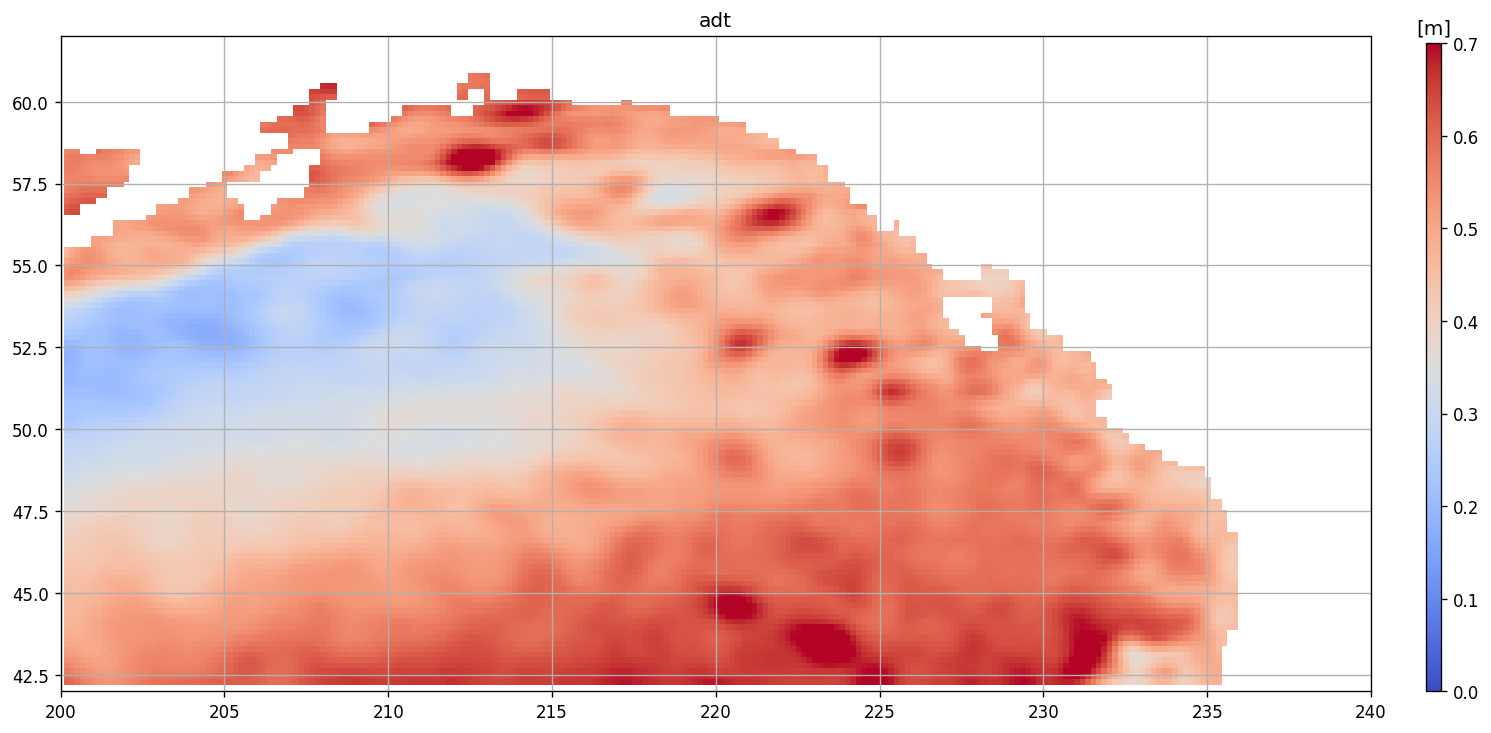

In [11]:
ax = start_axes("adt", extent=extent)
m = chl.display(ax, "adt", vmin=0, vmax=.7)
update_axes(ax, m, unit="[m]")

## chl display



We can now plot chl from `chl`



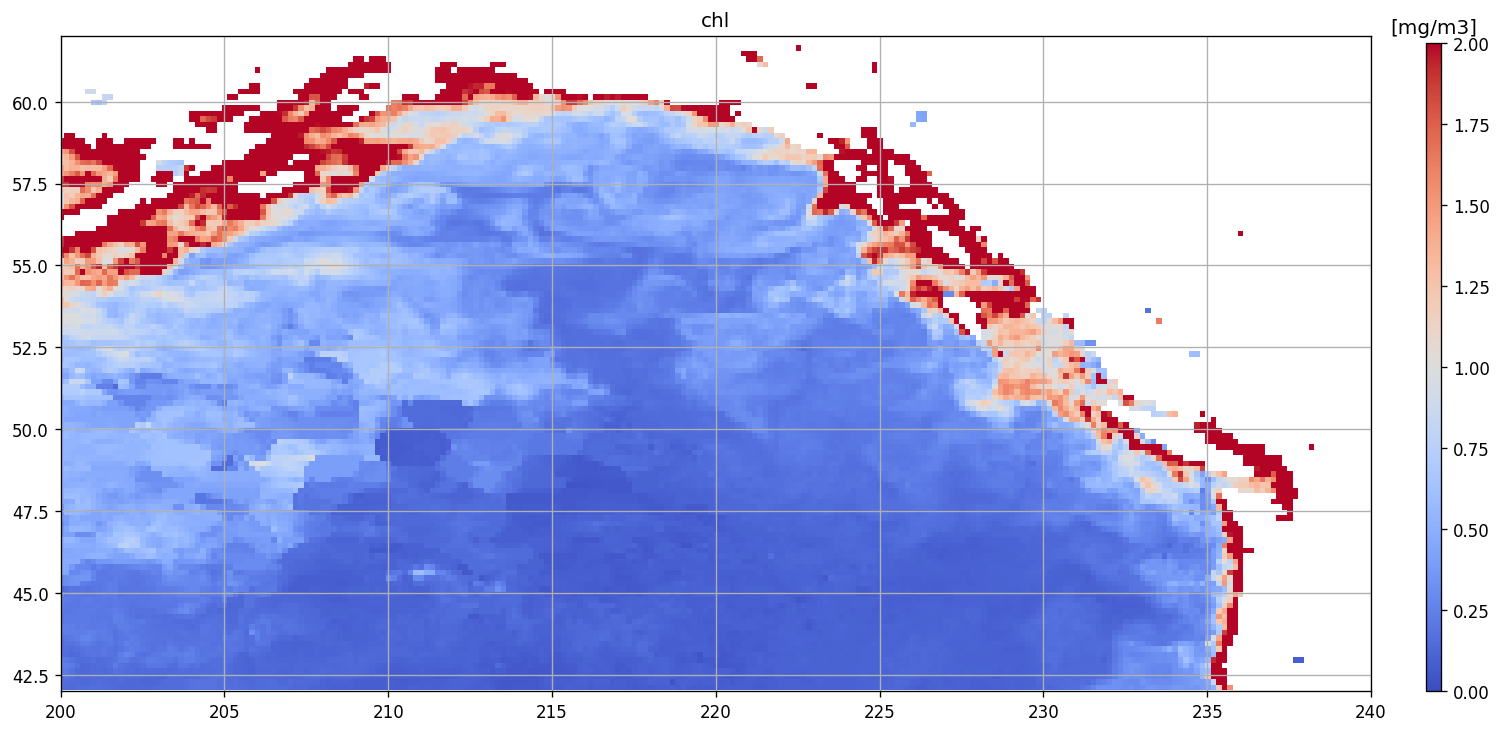

In [12]:
ax = start_axes("chl")
m = chl.display(ax, "chl", vmin=0, vmax=2)
update_axes(ax, m, unit="[mg/m3]")

### Overlay the circulation field (calculated from ADT) on top of the chl field

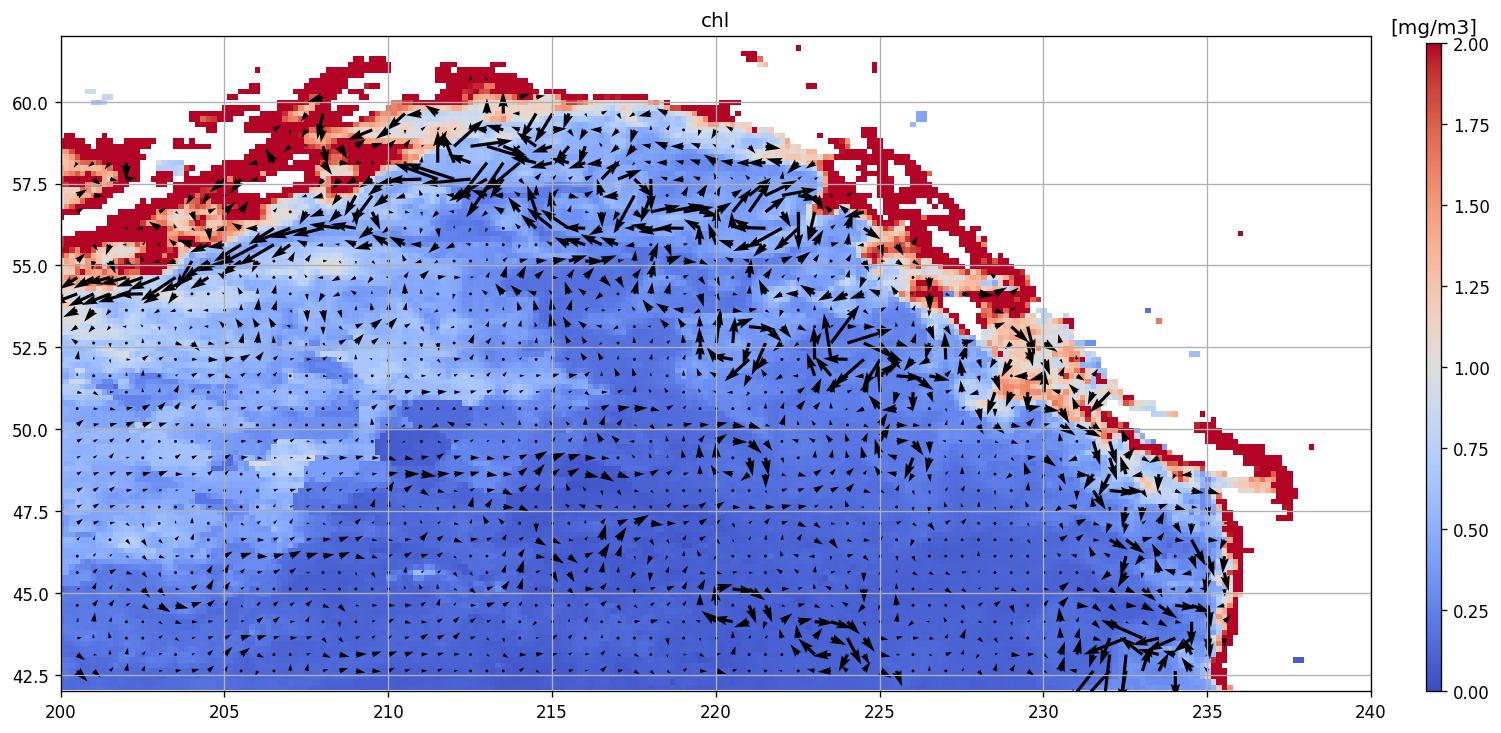

In [13]:
st = 3
ax = start_axes("chl")
m = chl.display(ax, "chl", vmin=0, vmax=2)
u, v = chl.grid("u").T, chl.grid("v").T
ax.quiver(chl.x_c[::st], chl.y_c[::st], u[::st, ::st], v[::st, ::st], scale=10)
update_axes(ax, m, unit="[mg/m3]")

Now, with eddy contours, and displaying SST anomaly



In [14]:
# ------------------------------------------------------------
# Apply spatial filter to select for the small scale features
# number is in the units of km
# ------------------------------------------------------------
chl.bessel_high_filter("chl", 400)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


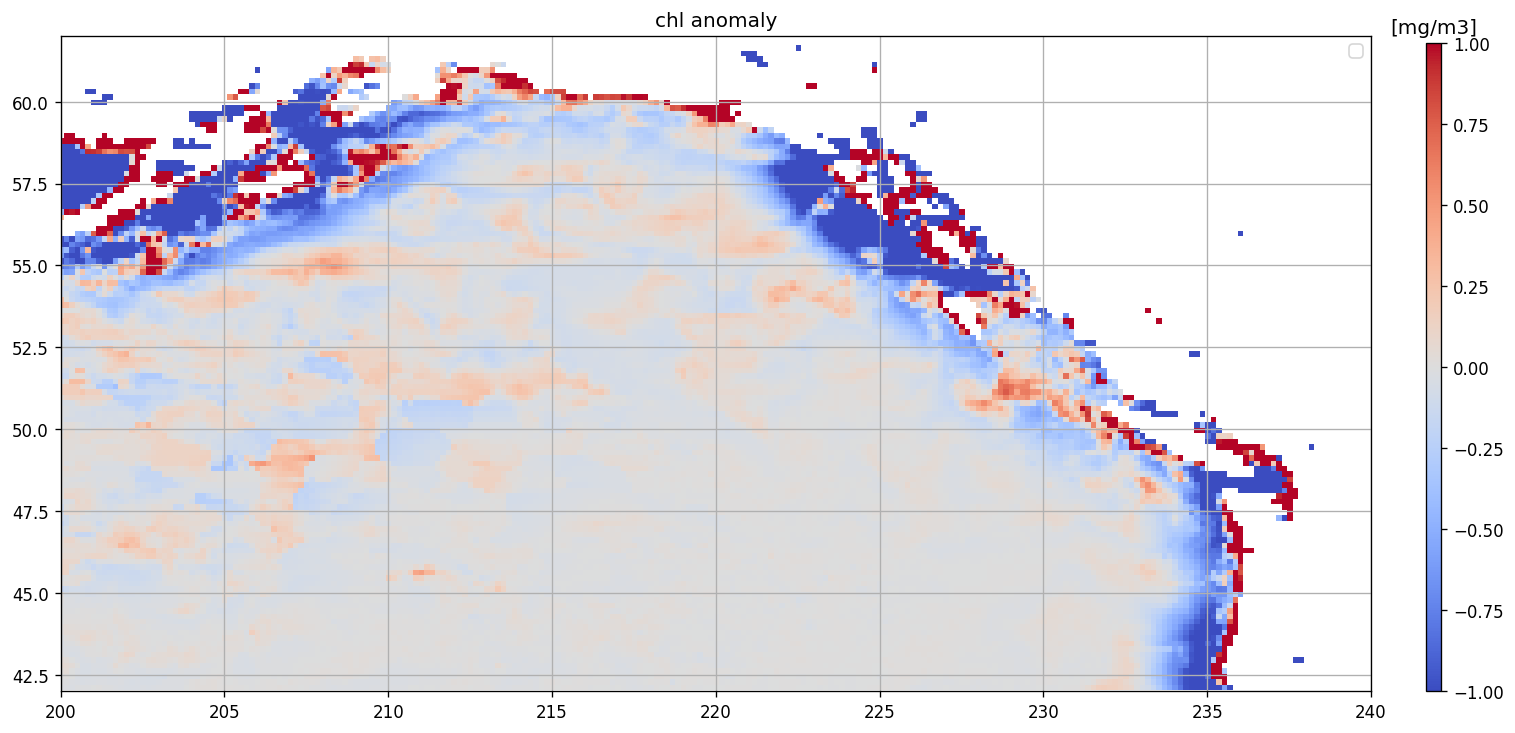

In [15]:
ax = start_axes("chl anomaly")
m = chl.display(ax, "chl", vmin=-1, vmax=1)
#m = chl.display(ax, "chl", vmin=0, vmax=2)
ax.legend()
#ax.quiver(chl.x_c[::st], chl.y_c[::st], u[::st, ::st], v[::st, ::st], scale=10)
update_axes(ax, m, unit="[mg/m3]")

## Eddy detection



In [18]:
chl.bessel_high_filter("adt", 400)

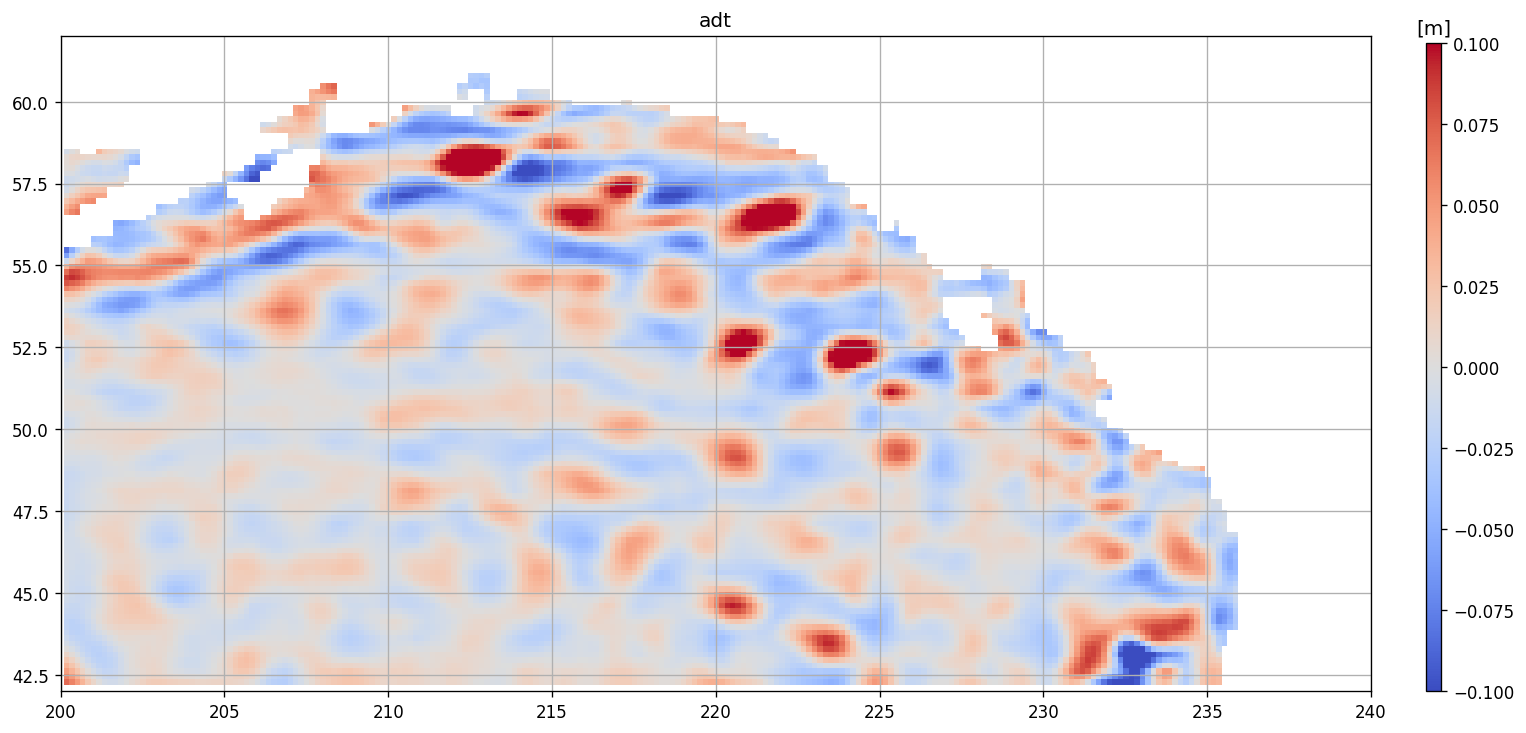

In [29]:
# ADT filtered
ax = start_axes("adt", extent=extent)
m = chl.display(ax, "adt", vmin=-0.1, vmax=0.1)
update_axes(ax, m, unit="[m]")
# -----------------------------------------------------------
# The eddy detection takes ssh, u, v velocities as input
#  additional input is date and step between two layers
# the 0.005 m (5mm) is the SSH cutoff for doing closed. 
# -----------------------------------------------------------
a, c = chl.eddy_identification("adt", "u", "v", date, 0.005)

In [31]:
kwargs_a = dict(lw=2, label="Anticyclonic", ref=-10, color="b")
kwargs_c = dict(lw=2, label="Cyclonic", ref=-10, color="r")

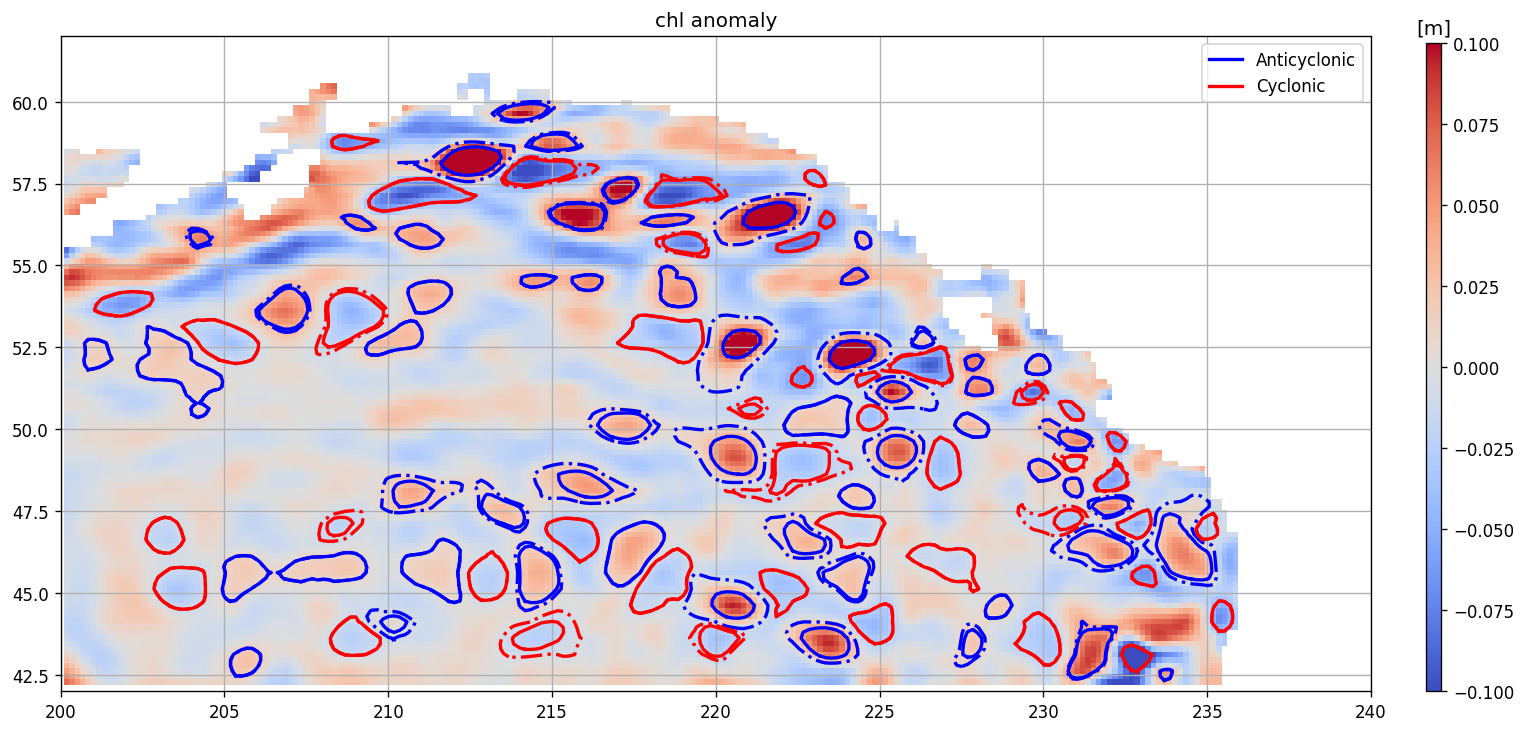

In [32]:
ax = start_axes("chl anomaly")
m = chl.display(ax, "adt", vmin=-.1, vmax=.1)
a.display(ax, **kwargs_a), c.display(ax, **kwargs_c)
ax.legend()
update_axes(ax, m, unit="[m]")

In [33]:
c

| 44 observations from 24350.0 to 24350.0 (1.0 days, ~44 obs/day)
    |   Speed area      : 0.32 Mkm²/day
    |   Effective area  : 0.38 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.00     52.27     25.00      6.82      4.55     11.36      0.00
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00     22.73     25.00     20.45     27.27      4.55      0.00      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00     13.64     27.27     13.64     34.09      9.09      2.27      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -15.00     15.00     60.00     90.00
        Percent of eddies         :       0.00      0.00      0.00    100.00      0.00
        Percent of speed area     :       0.00      0.00      0.00    100.00      0.00
        Percent of effective area :       0.00      0.00      0.00    100.00      0.00
        Mean speed radius (km)    :        nan       nan       nan     47.41       nan
        Mean effective radius (km):        nan       nan       nan     52.31       nan
        Mean amplitude (cm)       :        nan       nan       nan      2.56       nan

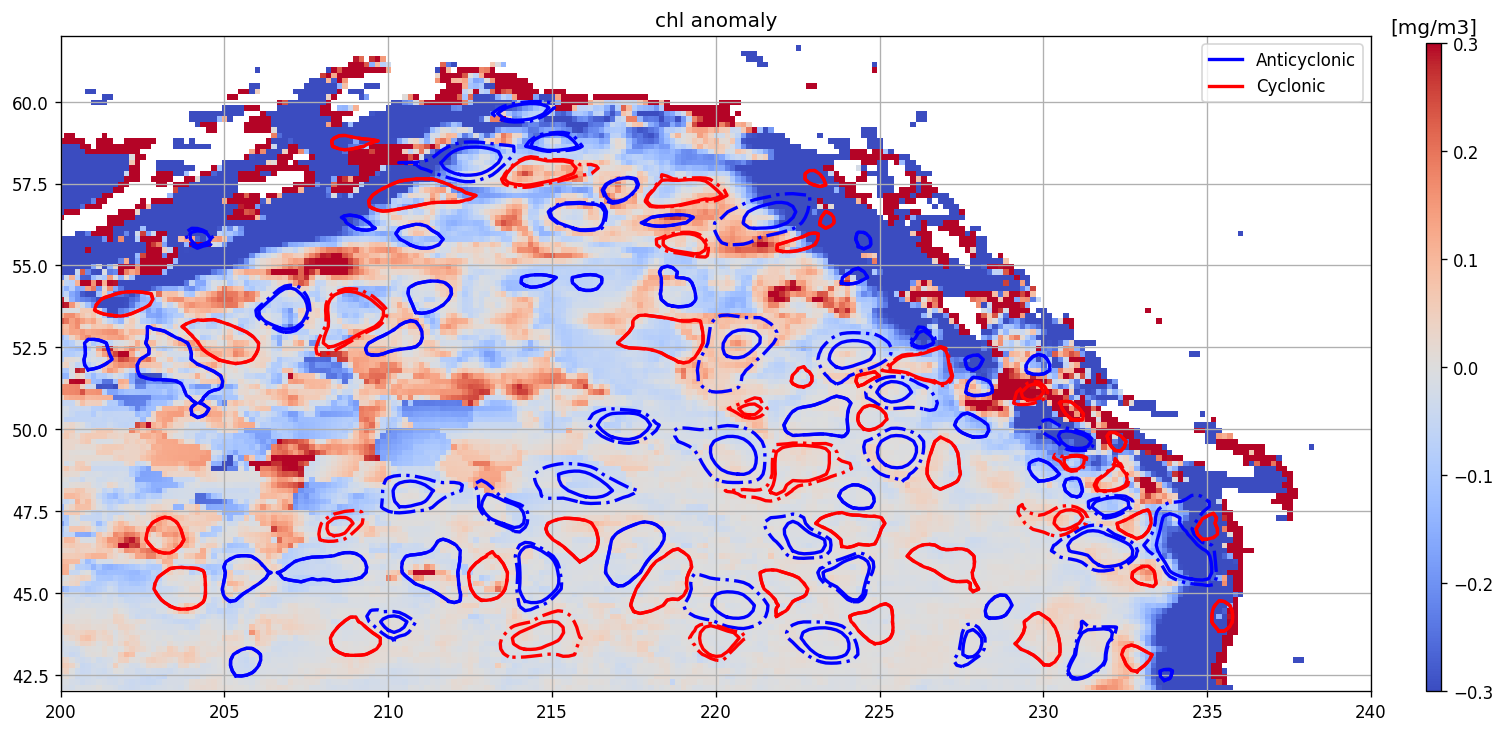

In [38]:
ax = start_axes("chl anomaly")
m = chl.display(ax, "chl", vmin=-0.3, vmax=0.3)
#m = chl.display(ax, "chl", vmin=0, vmax=2000)
a.display(ax, **kwargs_a), c.display(ax, **kwargs_c)
ax.legend()
update_axes(ax, m, unit="[mg/m3]")

## Example of post-processing
Get mean of chl anomaly_high in each internal contour



In [39]:
anom_a = a.interp_grid(chl, "chl", method="mean", intern=True)
anom_c = c.interp_grid(chl, "chl", method="mean", intern=True)

Are cyclonic (resp. anticyclonic) eddies generally associated with positive (resp. negative) chl anomaly ?



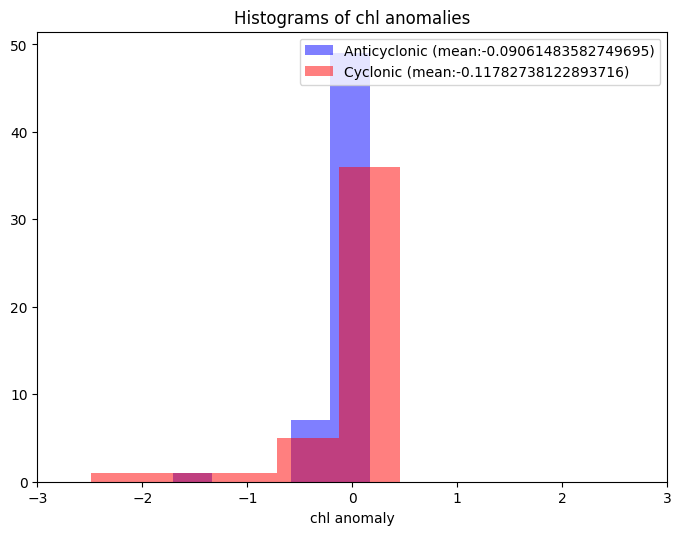

In [41]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0.05, 0.05, 0.90, 0.90])
ax.set_xlabel("chl anomaly")
#ax.set_xlim([0, 2000])
ax.set_xlim([-3, 3])
ax.set_title("Histograms of chl anomalies")
ax.hist(
    anom_a, 5, alpha=.5, color="b", label="Anticyclonic (mean:%s)" % (anom_a.mean())
)
ax.hist(anom_c, 5, alpha=.5, color="r", label="Cyclonic (mean:%s)" % (anom_c.mean()))
ax.legend()

In [42]:
import numpy as np

# Statsitical test (t-test)

# - H0 there is no significant difference in chl between cyclonic and anticyclonic eddies
# - H1 there is significant difference in chl
# - We use 95% confidence interval (two tail test)

# calculate the signal
chl_a = anom_a.mean()
print('average chl within anticyclone = '+str(round(chl_a,3))+' mg/m3')
chl_c = anom_c.mean()
print('average chl within cyclone = '+str(round(chl_c,3))+' mg/m3')
# 
signal_cma = chl_c - chl_a
# 
# calculate standard error
#
chl_a_stdev = anom_a.std()
print('stdev of chl within anticyclone = '+str(round(chl_a_stdev,3))+' mg/m3')
chl_c_stdev = anom_c.std()
print('stdev of chl within cyclone = '+str(round(chl_c_stdev,3))+' mg/m3')
# 
# combined standard deviation
N_a = np.size(anom_a)
N_c = np.size(anom_c)
print('there are '+str(N_a)+' anticyclones and '+str(N_c)+' cyclones')
chl_stdev = np.sqrt( ((N_a-1)*chl_a_stdev**2 + (N_c-1)*chl_c_stdev**2)/(N_a+N_c-2) )
print('combined stdev is '+str(round(chl_stdev,3))+' mg/m3')
# 
# calculate standard error
SE = chl_stdev*np.sqrt(1/N_a+1/N_c)
print('standard error is '+str(round(SE,3))+' mg/m3')
#
# calculate t statistic
tval = signal_cma/SE
print('t-value of the signal is '+str(abs(tval)))
#
# calculate the critical t-value
from scipy import stats

tcrit = stats.t.ppf(.975,N_a+N_c-2)
print('critical t-value is '+str(tcrit))

average chl within anticyclone = -0.091 mg/m3
average chl within cyclone = -0.118 mg/m3
stdev of chl within anticyclone = 0.248 mg/m3
stdev of chl within cyclone = 0.447 mg/m3
there are 57 anticyclones and 44 cyclones
combined stdev is 0.349 mg/m3
standard error is 0.07 mg/m3
t-value of the signal is 0.38858118173009715
critical t-value is 1.9842169515086827


In [ ]:
print(str(round(chl_a,3)))
print(str(round(chl_c,3)))
print(str(round(chl_a_stdev,3)))
print(str(round(chl_c_stdev,3)))
print(str(N_a))
print(str(N_c))
print(str(round(chl_stdev,3)))
print(str(round(SE,3)))
print(str(roundabs(tval)))
print('critical t-value is '+str(tcrit))

In [22]:
import netCDF4

netCDF4.getlibversion()

'4.9.1 of Mar  2 2023 00:43:31 $'

In [23]:
import numpy as np

np.version.version

'1.24.3'